# Inference with original cnn_virus trained model

This notebook is a guide showing how to use experiment with the pretrained model and infer/predict virus from the original data available with the paper.

# Imports and setup environment

### Install and import packages

In [1]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [8]:
# Import all required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from pathlib import Path
from pprint import pprint

# Setup the notebook for development
nb_setup()


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model
print(f"Tensorflow version: {tf.__version__}\n")

from metagentools.cnn_virus.data import strings_to_tensors, create_infer_ds_from_fastq
from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader
from metagentools.core import TextFileBaseIterator, TextFileBaseReader, ProjectFileSystem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode
Tensorflow version: 2.8.2



In [3]:
devices = device_lib.list_local_devices()
print('\nDevices:')
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':', 1) for item in name.split(', ')]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', ' ')
    print(f"  - {t}  {d.name} {dev:25s}")


Devices:
  - CPU  /device:CPU:0                          
  - GPU  /device:GPU:0  NVIDIA GeForce GTX 1050 


# 2. Setup paths to files

Key folders and system information

In [4]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


In [5]:
pfs.readme()

*/home/vtec/projects/bio/metagentools/data*

This directory includes all the data for the project `metagentools`.

```text
data
     |--- CNN_Virus_data  (all data related to CNN Virus original paper)
     |--- models          (trained and finetuned models)
     |--- ncbi            (refsequences, simreads, datasets and infer_results for CoV from NCBI)
     |--- ncov_data       (refsequences, simreads, datasets and infer_results for non CoV sequences)
     |--- ....            (raw and pre-processed data from various sources)  
     
```



- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model
- `p2original`: path to the directory with all paper files

In [6]:
p2model = pfs.data / 'models/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
assert p2virus_labels.is_file(), f"No file found at {p2virus_labels.absolute()}"

p2original = pfs.data / 'CNN_Virus_data'
assert p2original.is_dir(), f"No directory found at {p2original.absolute()}"

In [9]:
files_in_tree(path=p2original);

data
  |--CNN_Virus_data
  |    |--50mer_validating (0)
  |    |--150mer_ds_100_seq (1)
  |    |--validation_sequences.fasta (2)
  |    |--ICTV_150mer_benchmarking (3)
  |    |--50mer_ds_100_seq (4)
  |    |--50mer_training (5)
  |    |--training_sequences_500bp.fasta (6)
  |    |--weight_of_classes (7)
  |    |--virus_name_mapping (8)
  |    |--training_sequences_300bp.fasta (9)


# 3. Create inference dataset

The file `50mer_validating` is a validation dataset already in the expected format


```text
AAAAAGATTTTGAGAGAGGTCGACCTGTCCTCCTAAAACGTTTACAAAAG	71	0
CATGTAACGCAGCTTAGTCCGATCGTGGCTATAATCCGTCTTTCGATTTG	1	7
AACAACATCTTGTTGATGATAACCGTCAAAGTGTTTTGGGTCTGGAGGGA	158	6
AGTACCTGGAGAGCGTTAAGAAACACAAACGGCTGGATGTAGTGCCGCGC	6	7
CCACGTCGATGAAGCTCCGACGAGAGTCGGCGCTGAGCCCGCGCACCTCC	71	6
```

Each line corresponds to a **read sequence**. During inference, the model will predict the **virus species code** and the **relative position** of the read in the full reference sequence.

The mapping between code and virus specie name are in the file `virus_labels.csv`

In [11]:
p2ds = p2original / '50mer_validating'
val = TextFileBaseReader(p2ds, nlines=10)
val.print_first_chunks(nchunks=1)

10-line chunk 1
AAAAAGATTTTGAGAGAGGTCGACCTGTCCTCCTAAAACGTTTACAAAAG	71	0
CATGTAACGCAGCTTAGTCCGATCGTGGCTATAATCCGTCTTTCGATTTG	1	7
AACAACATCTTGTTGATGATAACCGTCAAAGTGTTTTGGGTCTGGAGGGA	158	6
AGTACCTGGAGAGCGTTAAGAAACACAAACGGCTGGATGTAGTGCCGCGC	6	7
CCACGTCGATGAAGCTCCGACGAGAGTCGGCGCTGAGCCCGCGCACCTCC	71	6
AGCTCGTGGATCTCCCCTCCTTCTGCAGTTTCAACATCAGAAGCCCTGAA	87	1
GACTCTGTGTTTATGTATCAGCATACAGAGCTTATGCAGAAGAACGCGTC	10	0
CGTCATGAGGAAGTTGCTAATAATATGTGGATGCATGCATTCCTCTGGGT	178	7
TTCACCTTGAGCAAGGGCAGGTTGAACACGCGGCTGACATCGCCGTCGTA	71	3
CAAAACTTTCACCGGGGTTCCAATCCGCGGTGGTAATGACGTTNTGCTGT	22	6



## Create the data loader for the model 

Define batch size and create a first dataset accessing data from the dataset text file. Batch size can be adjusted depending on the memory available on the GPU. For reference, `bs = 4096` was used with a 4GB GPU. 

Then transform the text dataset into a tensor dataset by applying the `string_to_tensor` preprocessing function

In [12]:
bs = 4096

text_ds = tf.data.TextLineDataset(p2ds).batch(bs)
ds = text_ds.map(strings_to_tensors)

The bases in the read sequences are encoded as a 5-dim one-hot-encoded vector, as the model expects.

In this example, each 50bp read in converted into a tensor of shape [50,5]

In [13]:
for batch, (y1b, y2b) in ds.take(1):
    # show the shape of one batch
    print(batch.shape)
    # show the forst 10 bases, after one-hot-endoding
    print(batch[0, :10, :])

(4096, 50, 5)
tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]], shape=(10, 5), dtype=float32)


# Experiments with original data

##  Setup paths

In [18]:
p2model = pfs.data / 'models/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

## Load pretrained model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [21]:
model = load_model(p2model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 50, 512)     2048        ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 25, 512)     0           ['batch_normalization_1[0][

## Inference/Prediction with Original Data

In [23]:
prob_preds_species, prob_preds_loc  = model.predict(ds, verbose=1)

245/245 [==============================] - 234s 960ms/step


In [24]:
prob_preds_species.shape, prob_preds_loc.shape

((1000000, 187), (1000000, 10))

In [28]:
class_preds = np.argmax(prob_preds_species, axis=1)
class_preds[:10]

array([ 71,   1, 158,   6,  71,  87,  10, 178,  71,  22])

In [30]:
class_labels_ohe = None
for xb, (yb, _) in ds:
    class_labels_ohe = tf.concat([class_labels_ohe, yb], axis=0) if class_labels_ohe is not None else yb
# print(class_labels_ohe.shape)
class_labels = np.argmax(class_labels_ohe, axis=1)
class_labels[:10]

array([ 71,   1, 158,   6,  71,  87,  10, 178,  71,  22])

In [31]:
acc = tf.keras.metrics.Accuracy()
acc(class_labels, class_preds).numpy()

0.947462

In [70]:
from sklearn.metrics import precision_score, recall_score

`average`
- `binary`: Only report results for the class specified by ``pos_label``. This is applicable only if targets (``y_{true,pred}``) are binary.
- `micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.
- `macro`: Calculate metrics for each label, and find their unweighted mean.  This does not take label imbalance into account.

In [69]:
precision_score(class_labels, class_preds, average='macro')

0.9571694535807757

In [71]:
recall_score(class_labels, class_preds, average='macro')

0.9497351978486862

**Confusion Matrix**
The matrix **columns** represent the prediction labels and the **rows** represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Confusion Matrix**
The matrix **columns** represent the prediction labels and the **rows** represent the real labels. The confusion matrix is always a 2-D array of shape [n, n], where n is the number of valid labels for a given classification task.

In [43]:
# tf.math.confusion_matrix?

In [48]:
confmat = tf.math.confusion_matrix(class_labels, class_preds)
confmat.shape

TensorShape([187, 187])

In [49]:
confmat[:5,:5]

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[30620,     2,     0,     3,    55],
       [    0,  4216,     3,     0,     4],
       [    4,     0, 36028,    13,    22],
       [    4,     1,    25,  6861,     7],
       [   57,     3,    18,     2, 27612]], dtype=int32)>

Review errors

In [50]:
# np.fill_diagonal?

In [51]:
confmat_no_diag = confmat.numpy().copy()
np.fill_diagonal(confmat_no_diag, 0)
confmat_no_diag[:5,:5]

array([[ 0,  2,  0,  3, 55],
       [ 0,  0,  3,  0,  4],
       [ 4,  0,  0, 13, 22],
       [ 4,  1, 25,  0,  7],
       [57,  3, 18,  2,  0]], dtype=int32)

In [54]:
non_zeroes = confmat_no_diag.flatten()[confmat_no_diag.flatten() > 0]
small_vals = confmat_no_diag.flatten()[(confmat_no_diag.flatten() > 0) & (confmat_no_diag.flatten() < 10)]
np.median(non_zeroes), np.percentile(non_zeroes, 80), non_zeroes.max()

(1.0, 3.0, 4069)

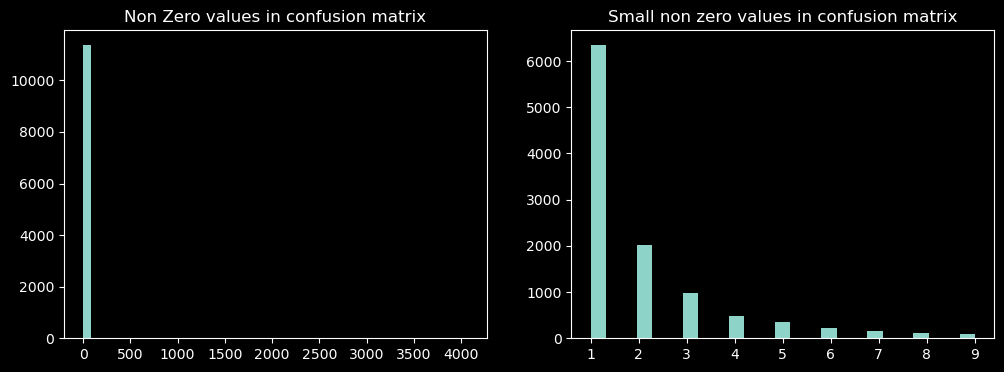

In [55]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(non_zeroes, bins=50)
ax1.set_title('Non Zero values in confusion matrix')
ax2.hist(small_vals, bins=25)
ax2.set_title('Small non zero values in confusion matrix')
plt.show()

In [56]:
confmat.numpy().max(), np.median(confmat.numpy()), np.percentile(confmat.numpy(), 99)

(44229, 0.0, 27.0)

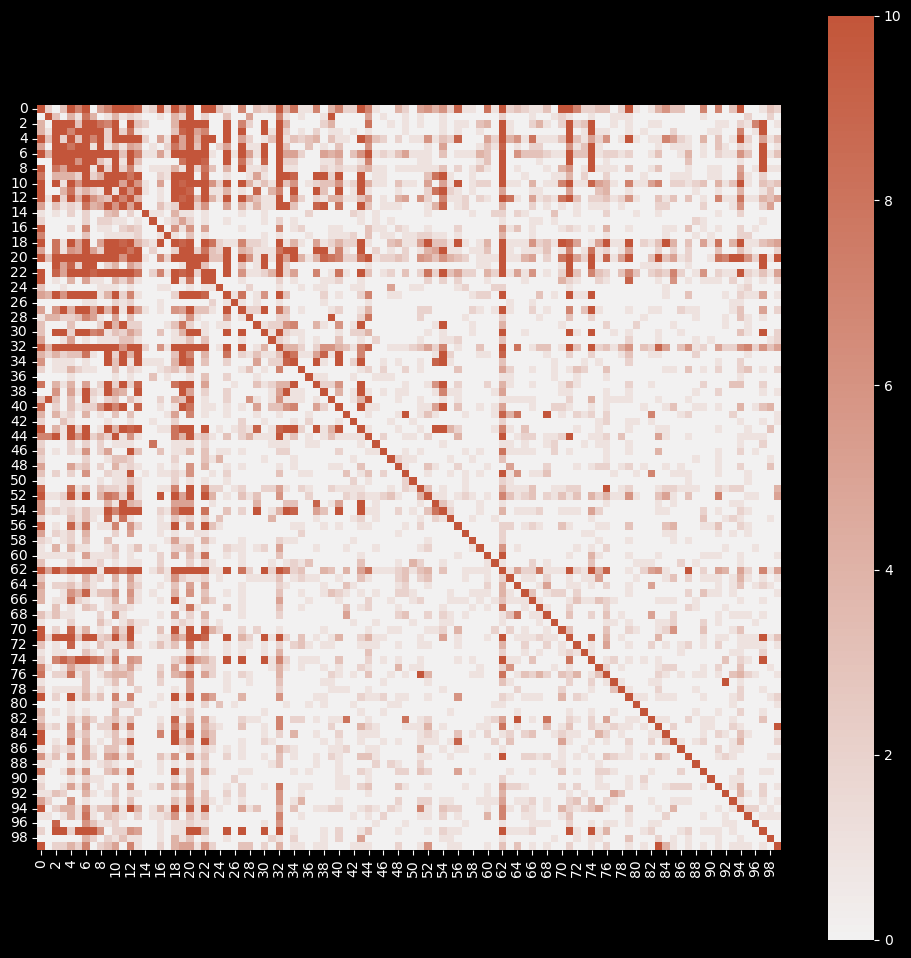

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# cmap = sns.color_palette("flare", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(confmat[:100,:100], center=0, vmax=10, cmap=cmap, square=True, ax=ax);

In [83]:
true_nbr_samples_per_virus = confmat.numpy().sum(axis=1)
pred_nbr_samples_per_virus = confmat.numpy().sum(axis=0)
# print(true_nbr_samples_per_virus)
# print(pred_nbr_samples_per_virus)

In [84]:
test_prec = np.diagonal(confmat.numpy()) / pred_nbr_samples_per_virus
# print(test_prec)

In [85]:
test_recall = np.diagonal(confmat.numpy()) / true_nbr_samples_per_virus
# print(test_recall)

In [86]:
n = 50
smallest_prec = np.argsort(test_prec)[0:n]
smallest_recall = np.argsort(test_recall)[0:n]
display(smallest_prec)
display(smallest_recall)
smallest_prec_and_recall = np.array(list(set(smallest_prec).intersection(set(smallest_recall))))
smallest_prec_and_recall

array([  0,  18,  12,   4,  74,  16,  27,  79,  66, 129, 181,  76,  94,
       173, 114, 176, 120,  64, 148,  25,  91, 127,   5,  42,  98,  72,
        99, 145, 117,  89,  97,   6,  56, 137,  86,  78,   8, 112, 106,
       109, 134,  31, 177, 164, 126,  20,  47, 160, 144,  92])

array([  0,  18,   4,  12, 178, 161,  61,  82, 112, 133, 116,  90, 141,
       108,  46,  30, 151,  97, 149, 163, 142, 138,  77,  92, 179, 157,
       158,  14, 152, 119,  84, 120, 109, 124,  55,  87, 137,  89,  58,
         3,  41,  93, 166, 173,  45, 150, 107,  51,   7, 154])

array([  0,  97,   4, 137,  12, 173, 109, 112,  18, 120,  89,  92])

In [87]:
p2virus_class_mapping = pfs.data /'CNN_Virus_data/virus_name_mapping'
with open(p2virus_class_mapping, 'r') as fp:
    label2virus = []
    virus2label = {}
    while True:
        line = fp.readline()[:-1]
        if line == '': break
        virus, label = line.split('\t')
        label2virus.append(virus)
        virus2label[virus] = label
label2virus=np.array(label2virus)

In [88]:
label2virus[smallest_prec_and_recall].tolist()

['Variola_virus',
 'Human_mastadenovirus_D',
 'Human_betaherpesvirus_6B',
 'Japanese_encephalitis_virus',
 'Human_betaherpesvirus_6A',
 'Cosavirus_A',
 'Tai_Forest_ebolavirus',
 'Barmah_Forest_virus',
 'Monkeypox_virus',
 'Reston_ebolavirus',
 'Oropouche_orthobunyavirus',
 'Enterovirus_F']

In [89]:
label2virus[smallest_prec].tolist()

['Variola_virus',
 'Monkeypox_virus',
 'Human_betaherpesvirus_6A',
 'Human_betaherpesvirus_6B',
 'Human_mastadenovirus_G',
 'Hendra_henipavirus',
 'Human_mastadenovirus_F',
 'Rotavirus_B',
 'Influenza_C_virus',
 'Nipah_henipavirus',
 'Enterovirus_K',
 'Crimean-Congo_hemorrhagic_fever_orthonairovirus',
 'Middle_East_respiratory_syndrome-related_coronavirus',
 'Cosavirus_A',
 'Cosavirus_B',
 'Enterovirus_I',
 'Reston_ebolavirus',
 'Rabies_lyssavirus',
 'Enterovirus_D',
 'Human_alphaherpesvirus_1',
 'Mumps_rubulavirus',
 'Chandipura_vesiculovirus',
 'Human_mastadenovirus_B',
 'Human_polyomavirus_5',
 'Mupapillomavirus_2',
 'Punta_Toro_phlebovirus',
 'Zaire_ebolavirus',
 'Eastern_equine_encephalitis_virus',
 'Severe_acute_respiratory_syndrome-related_coronavirus',
 'Oropouche_orthobunyavirus',
 'Human_mastadenovirus_D',
 'Human_betaherpesvirus_5',
 'Rotavirus_G',
 'Japanese_encephalitis_virus',
 'Mamastrovirus_8',
 'Enterovirus_C',
 'Human_mastadenovirus_A',
 'Barmah_Forest_virus',
 'Prima

In [90]:
label2virus[smallest_recall].tolist()

['Variola_virus',
 'Monkeypox_virus',
 'Human_betaherpesvirus_6B',
 'Human_betaherpesvirus_6A',
 'Mamastrovirus_14',
 'Enterovirus_J',
 'Human_polyomavirus_10',
 'Australian_bat_lyssavirus',
 'Barmah_Forest_virus',
 'Mamastrovirus_6',
 'Primate_erythroparvovirus_4',
 'Mamastrovirus_16',
 'Parechovirus_C',
 'Sudan_ebolavirus',
 'Dengue_virus',
 'Human_mastadenovirus_E',
 'Rosavirus_A',
 'Human_mastadenovirus_D',
 'Rhinovirus_B',
 'Banna_virus',
 'Rhinovirus_C',
 'Rotavirus_D',
 'Enterovirus_E',
 'Enterovirus_F',
 'Sapporo_virus',
 'Enterovirus_H',
 'Enterovirus_L',
 'Human_polyomavirus_12',
 'Rhinovirus_A',
 'Bunyamwera_orthobunyavirus',
 'Human_respirovirus_3',
 'Reston_ebolavirus',
 'Tai_Forest_ebolavirus',
 'Lymphocytic_choriomeningitis_mammarenavirus',
 'Mupapillomavirus_3',
 'Measles_morbillivirus',
 'Japanese_encephalitis_virus',
 'Oropouche_orthobunyavirus',
 'Primate_erythroparvovirus_3',
 'Human_mastadenovirus_C',
 'European_bat_1_lyssavirus',
 'Machupo_mammarenavirus',
 'Mayar

In [91]:
smallest_df = pd.DataFrame(
    data=confmat.numpy()[smallest_prec_and_recall, :][:, smallest_prec_and_recall], 
    index=label2virus[smallest_prec_and_recall], 
    columns=label2virus[smallest_prec_and_recall], 
)

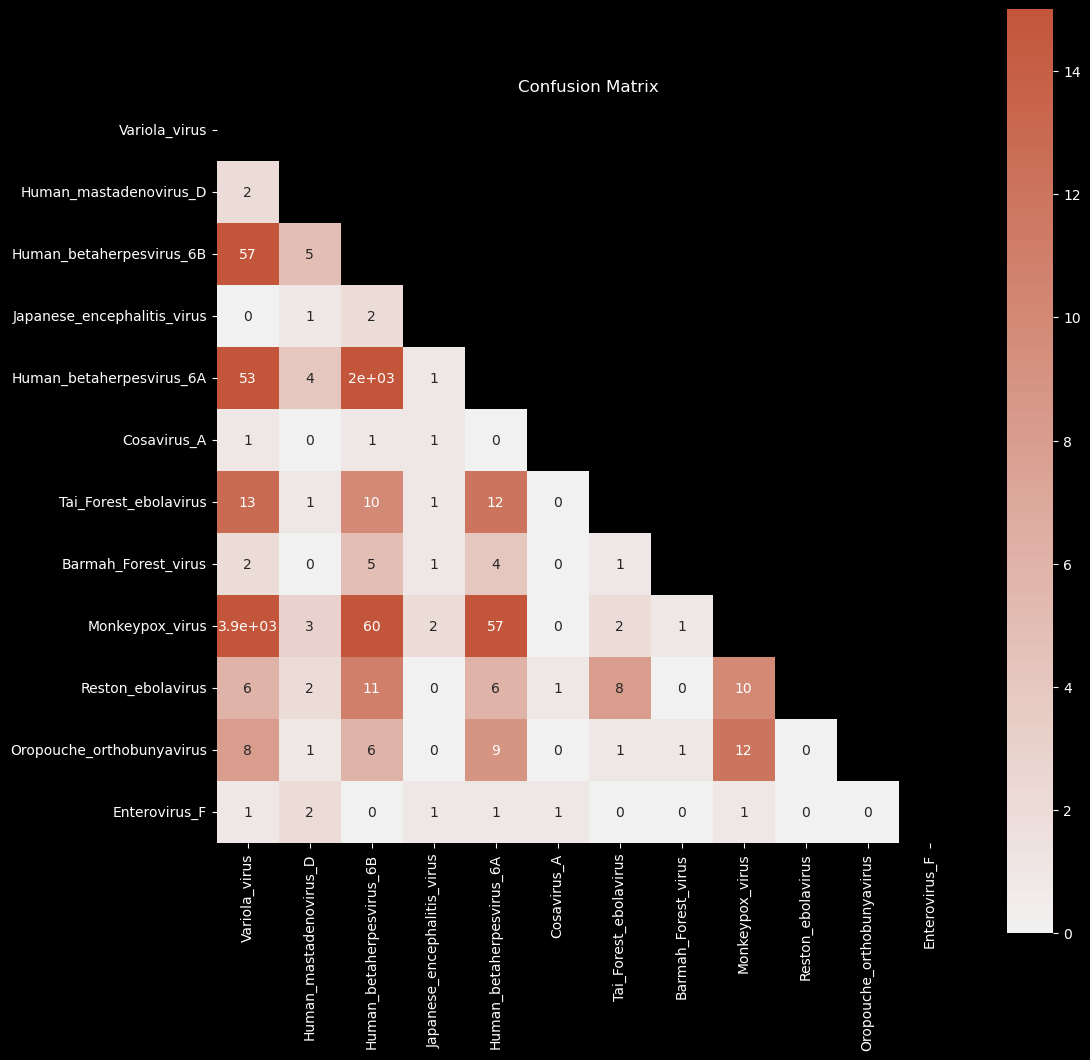

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_title('Confusion Matrix')
mask = np.zeros_like(smallest_df.values)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(smallest_df, mask=mask, center=0, vmax=15, cmap=cmap, square=True, annot=True, ax=ax);

# New Section